In [3]:
from google.colab import drive
drive.mount('/content/mydrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/mydrive


In [0]:
# Imports

from imutils import paths
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [0]:
# Constants

DATA_PATH = '/content/mydrive/My Drive/mask_dataset'

In [0]:
# Hyper parameters space

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [18]:
print("[INFO] Loading the images")
data = []
labels = []

imagePaths = list(paths.list_images(DATA_PATH))

# loop over the image paths
for imagePath in tqdm(imagePaths):
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)



  2%|▏         | 22/1385 [00:00<00:06, 219.32it/s]

[INFO] Loading the images


100%|██████████| 1385/1385 [00:05<00:00, 236.13it/s]


In [0]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [24]:
# Loading the mobilenetv2 architecture

baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)


# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [25]:
print("[INFO] compiling model...")

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")

H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
34/34 [==============================] - 12s 343ms/step - loss: 0.4612 - accuracy: 0.7950 - val_loss: 0.0966 - val_accuracy: 0.9892
Epoch 2/20
34/34 [==============================] - 10s 307ms/step - loss: 0.1393 - accuracy: 0.9591 - val_loss: 0.0459 - val_accuracy: 0.9892
Epoch 3/20
34/34 [==============================] - 11s 310ms/step - loss: 0.0891 - accuracy: 0.9740 - val_loss: 0.0359 - val_accuracy: 0.9892
Epoch 4/20
34/34 [==============================] - 11s 315ms/step - loss: 0.0609 - accuracy: 0.9814 - val_loss: 0.0271 - val_accuracy: 0.9892
Epoch 5/20
34/34 [==============================] - 11s 310ms/step - loss: 0.0461 - accuracy: 0.9907 - val_loss: 0.0232 - val_accuracy: 0.9892
Epoch 6/20
34/34 [==============================] - 11s 309ms/step - loss: 0.0431 - accuracy: 0.9879 - val_loss: 0.0197 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 11s 312ms/step - loss: 0.0318 - accuracy

In [26]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('/content/mydrive/My Drive/mask_detector.h5', save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       139

    accuracy                           1.00       277
   macro avg       1.00      1.00      1.00       277
weighted avg       1.00      1.00      1.00       277

[INFO] saving mask detector model...


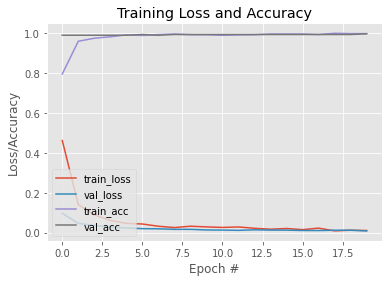

In [28]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
%matplotlib inline
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
